# Action 2 : 기여도 분석 및 시뮬레이션을 통한 예산 최적화
- 도메인 기반 및 Absorbing Markov Chain Attribution Model을 이용한 채널 기여도 분석

---

---

---

# 데이터 살펴보기
- 전자 제품 이커머스 회사는 채널을 통해 광고를 집행하고 있다고 가정
- 채널 : Facebook, Instagram, Paid Search, Online Video, Online Display

In [1]:
df = pd.read_csv('data/attribution_data.csv')

print(df.shape)
df.head(3)

(586737, 6)


,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


In [3]:
for col in df.columns:
    print(f"{col} : Unique Classes {df[col].nunique()}")

cookie : Unique Classes 240108
time : Unique Classes 485110
interaction : Unique Classes 2
conversion : Unique Classes 2
conversion_value : Unique Classes 11
channel : Unique Classes 5


In [4]:
print(f"Channel : {df.channel.unique()}")
print(f"Conversion Value : {df.conversion_value.unique()}")

Channel : ['Instagram' 'Online Display' 'Paid Search' 'Facebook' 'Online Video']
Conversion Value : [0.  6.5 8.  6.  7.5 7.  5.  4.5 5.5 8.5 4. ]


In [5]:
df.interaction.value_counts()

impression    569098
conversion     17639
Name: interaction, dtype: int64

In [6]:
df.interaction.value_counts(normalize=True)

impression    0.969937
conversion    0.030063
Name: interaction, dtype: float64

In [7]:
df.channel.value_counts()

Facebook          175741
Paid Search       151440
Online Video      113302
Instagram          75201
Online Display     71053
Name: channel, dtype: int64

In [8]:
# 쿠키(유저)별 노출된 Unique한 채널 수 
channel_per_cookie = df.groupby('cookie')['channel'].nunique().reset_index()
channel_per_cookie[:5]

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,2
1,0000nACkD9nFkBBDECD3ki00E,1
2,0003EfE37E93D0BC03iBhBBhF,1
3,00073CFE3FoFCn70fBhB3kfon,1
4,00079hhBkDF3k3kDkiFi9EFAD,1


In [9]:
# Unique 노출 채널 수별 쿠키 수
cookie_per_channel = channel_per_cookie.groupby('channel').count()
cookie_per_channel['rate'] = cookie_per_channel.divide(cookie_per_channel.cookie.sum())
cookie_per_channel

,cookie,rate
channel,,
1,183020,0.762240
2,45964,0.191431
3,9549,0.039770
4,1473,0.006135
5,102,0.000425


---

### 정리
- 데이터의 행은 쿠키의 전환 여부 및 전환 가치에 대한 정보로 구성되어 있다.
- 결측 데이터는 존재하지 않으며, 5개의 채널과 11개의 전환 가치로 channel, conversion_value 컬럼이 구성되어 있다.
- 전환된 데이터는 전체의 약 3%를 차지하고 있다.
- 쿠키별 노출된 채널 수는 1이 전체 중 약 76%를 차지하며, 순차적으로 19%, 4%, 0.6%, 0.04% 를 차지하고 있다.

---

---

# 도메인 기반 기여도 분석
- Last, First, Linear Interaction Attribution Model을 이용해 각 채널별 기여도를 계산

In [10]:
# 쿠키 및 시간에 대해 데이터 정렬
df['timestamp'] = pd.to_datetime(df['time'])
df.sort_values(['cookie', 'timestamp'], inplace=True)

df.drop('timestamp', axis=1, inplace=True)
df.head(2)

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display


## Last Interaction Attribution Model
- 마지막으로 노출/클릭된 채널의 기여도를 100%로 가정

In [11]:
# 쿠키별 마지막 데이터에 대해서만 추출
last_interaction_df = (
    df.drop_duplicates('cookie', keep='last')[['cookie', 'channel', 'conversion', 'conversion_value']]
)

print(last_interaction_df.shape)
last_interaction_df.head(2)

(240108, 4)


,cookie,channel,conversion,conversion_value
3,00000FkCnDfDDf0iC97iC703B,Online Display,0,0.0
9,0000nACkD9nFkBBDECD3ki00E,Paid Search,0,0.0


In [12]:
# 전환이 된 쿠키 및 해당 쿠키에 대한 채널 추출
conversion_interaction = df[df.conversion == 1]
print(f"Length :{len(conversion_interaction)}, Unique Cookies :{conversion_interaction.cookie.nunique()}")

# 전환이 된 쿠키 및 해당 쿠키의 마지막 채널 추출
last_conversion_interaction = last_interaction_df.loc[last_interaction_df.conversion == 1]
print(f"Length :{len(last_conversion_interaction)}, Unique Cookies :{last_conversion_interaction.cookie.nunique()}")
print()

# 두 데이터셋의 전환된 쿠키 및 채널이 동일한지 파악
print(set(conversion_interaction.cookie) - set(last_conversion_interaction.cookie))
print(set(conversion_interaction.channel) - set(last_conversion_interaction.channel))

Length :17639, Unique Cookies :17639
Length :17639, Unique Cookies :17639

set()
set()


- 두 데이터셋의 전환된 쿠키가 동일하고, 전환 당시 채널과 마지막 채널이 동일하므로 **쿠키가 전환이 된 경우, 해당 쿠키의 여정은 종료된다고 할 수 있다.**

---

In [13]:
conversion_interaction = conversion_interaction[['cookie', 'channel', 'conversion', 'conversion_value']]
conversion_interaction.head(2)

,cookie,channel,conversion,conversion_value
22,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,6.5
23,00090n9EBBEkA000C7Cik999D,Facebook,1,8.0


In [14]:
# 채널별 전환 수와 전환 가치의 합을 추출하기 위한 그룹핑
sort_datas = conversion_interaction.groupby('channel')[['conversion', 'conversion_value']].agg(['count', 'sum'])

In [15]:
# last interaction attribution model을 통한 채널별 기여도
last_interaction_attr = pd.DataFrame(
    {
    'attribution_cnt': sort_datas[('conversion', 'count')] ,
    'attribution_sum': sort_datas[('conversion_value', 'sum')]
    }, index=sort_datas.index)

last_interaction_attr

,attribution_cnt,attribution_sum
channel,,
Facebook,5301,33143.5
Instagram,2244,14039.5
Online Display,2139,13298.5
Online Video,3408,21418.0
Paid Search,4547,28331.5


---

---

## First Interaction Attribution Model
- 처음으로 노출/클릭된 채널의 기여도를 100%로 가정

In [16]:
# 쿠키별 첫번째 데이터에 대해서만 추출
first_interaction_df = (
    df.drop_duplicates('cookie', keep='first')[['cookie', 'channel']]
)

first_interaction_df.head(2)

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,Instagram
4,0000nACkD9nFkBBDECD3ki00E,Paid Search


In [17]:
# 쿠키별 첫번째 데이터에서 전환된 쿠키만 추출해 전환 가치 데이터와 병합
first_interaction_conversion = (
    first_interaction_df[['cookie', 'channel']]
    .merge(conversion_interaction[['cookie', 'conversion', 'conversion_value']], on='cookie')
)

first_interaction_conversion.head(2)

,cookie,channel,conversion,conversion_value
0,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,6.5
1,00090n9EBBEkA000C7Cik999D,Facebook,1,8.0


In [18]:
# 첫번째 채널에 대한 채널별 전환 수 및 전환 가치 합을 추출하기 위한 그룹핑
sort_datas = first_interaction_conversion.groupby('channel')[['conversion', 'conversion_value']].agg(['count', 'sum'])

In [19]:
# first interaction attribution model을 통한 채널별 기여도
first_interaction_attr = pd.DataFrame(
    {
    'attribution_cnt': sort_datas[('conversion', 'count')] ,
    'attribution_sum': sort_datas[('conversion_value', 'sum')]
    }, index=sort_datas.index)

first_interaction_attr

,attribution_cnt,attribution_sum
channel,,
Facebook,5177,32283.0
Instagram,2329,14579.5
Online Display,2160,13419.0
Online Video,3216,20225.5
Paid Search,4757,29724.0


---

---

## Linear Interaction Attribution Model
- 전환 과정 중 발생한 모든 채널의 기여도가 동일하다고 가정

In [20]:
# 유저 및 채널에 대해 중복되는 데이터 제거
unique_cookie_channel = df.drop_duplicates(['cookie', 'channel'], keep='last')[['cookie', 'channel']]

In [21]:
# 쿠키별 노출된 채널 및 채널 수
cookie_channel_df = unique_cookie_channel.merge(
    channel_per_cookie, on='cookie'
).rename({'channel_x': 'channel', 'channel_y': 'channel_cnt'}, axis=1)

cookie_channel_df.head(2)

,cookie,channel,channel_cnt
0,00000FkCnDfDDf0iC97iC703B,Instagram,2
1,00000FkCnDfDDf0iC97iC703B,Online Display,2


In [22]:
# 전환된 쿠키에 대해서만 추출해 전환 및 전환 가치 데이터 병합
linear_interaction_conversion = cookie_channel_df.merge(
    conversion_interaction[['cookie', 'conversion', 'conversion_value']], on='cookie'
)

linear_interaction_conversion.head(2)

,cookie,channel,channel_cnt,conversion,conversion_value
0,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,1,6.5
1,00090n9EBBEkA000C7Cik999D,Facebook,1,1,8.0


In [23]:
# 쿠키별 전환 / 노출된 채널 수로 나눠 각 채널의 가중치를 균등하게 배분
linear_interaction_conversion['linear_cnv'] = (
    linear_interaction_conversion.conversion / linear_interaction_conversion.channel_cnt
)

# 쿠키별 전환 가치 / 노출된 채널 수로 나눠 전환 가치를 균등하게 배분
linear_interaction_conversion['linear_val'] = (
    linear_interaction_conversion.conversion_value / linear_interaction_conversion.channel_cnt
)

linear_interaction_conversion.head()

,cookie,channel,channel_cnt,conversion,conversion_value,linear_cnv,linear_val
0,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,1,6.5,1.0,6.50
1,00090n9EBBEkA000C7Cik999D,Facebook,1,1,8.0,1.0,8.00
2,000h3n9nC0hFhE3CCnkkAof7n,Facebook,1,1,6.0,1.0,6.00
3,000hCBnCB7oi7ADAEnEBCnBEE,Instagram,2,1,6.5,0.5,3.25
4,000hCBnCB7oi7ADAEnEBCnBEE,Online Video,2,1,6.5,0.5,3.25


In [24]:
sort_datas = linear_interaction_conversion.groupby("channel")[['linear_cnv', 'linear_val']].sum()

In [25]:
# linear interaction attribution model을 통한 채널별 기여도
linear_interaction_attr = pd.DataFrame(
    {
        'attribution_cnt': sort_datas['linear_cnv'],
        'attribution_sum': sort_datas['linear_val']
    }, index=sort_datas.index
)

linear_interaction_attr

,attribution_cnt,attribution_sum
channel,,
Facebook,4947.600000,30910.008333
Instagram,2627.100000,16442.758333
Online Display,2143.600000,13324.466667
Online Video,3192.183333,20066.175000
Paid Search,4728.516667,29487.591667


---

---

## 도메인 기반 기여도 분석 모델 비교

In [26]:
import seaborn as sns


sns.set_theme(style="whitegrid", palette="Paired")

In [27]:
last_interaction_attr['method'] = 'last'
first_interaction_attr['method'] = 'first'
linear_interaction_attr['method'] = 'linear'

In [28]:
# 세 개의 모델을 병합한 후, 전환 가치 합 / 전환 수를 통해 전환당 전환 가치에 대한 컬럼 생성
domain_attr = pd.concat([last_interaction_attr, first_interaction_attr, linear_interaction_attr])
domain_attr['attribution_rate'] = domain_attr['attribution_sum'] / domain_attr['attribution_cnt']

domain_attr

,attribution_cnt,attribution_sum,method,attribution_rate
channel,,,,
Facebook,5301.000000,33143.500000,last,6.252311
Instagram,2244.000000,14039.500000,last,6.256462
Online Display,2139.000000,13298.500000,last,6.217158
Online Video,3408.000000,21418.000000,last,6.284624
Paid Search,4547.000000,28331.500000,last,6.230812
Facebook,5177.000000,32283.000000,first,6.235851
Instagram,2329.000000,14579.500000,first,6.259983
Online Display,2160.000000,13419.000000,first,6.212500
Online Video,3216.000000,20225.500000,first,6.289024


---

### Domain Based Interaction Attribution Model에 대한 채널별 전환 수 및 전환당 전환 가치 Chart

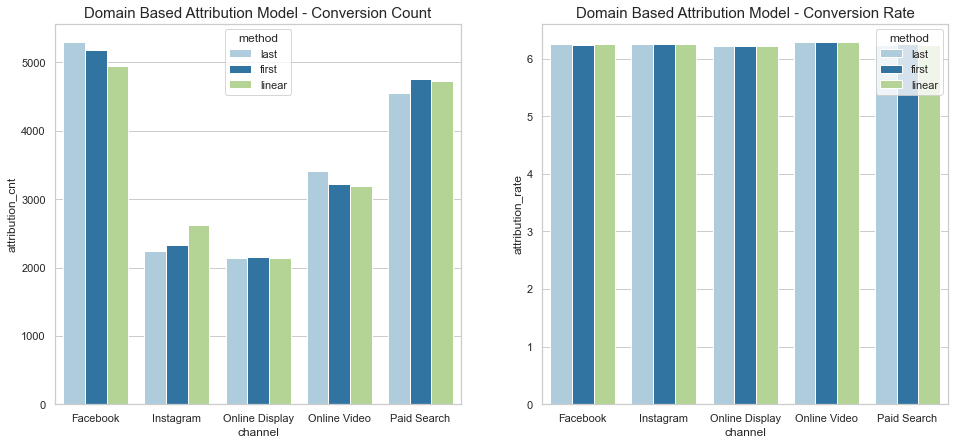

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

ax1 = sns.barplot(x=domain_attr.index, y=domain_attr.attribution_cnt, hue=domain_attr.method, ax=axes[0])
ax1.set_title("Domain Based Attribution Model - Conversion Count", size=15)

ax2 = sns.barplot(x=domain_attr.index, y=domain_attr.attribution_rate, hue=domain_attr.method, ax=axes[1])
ax2.set_title("Domain Based Attribution Model - Conversion Rate", size=15)
# ax2.set_ylim(6.15, domain_attr.attribution_rate.max())

plt.show()

**Conversion Count**
- 페이스북 : Last Attribution일 때, 전환율이 가장 높음
    - 유저들이 전환하기 직전에 마지막으로 본 채널이 페이스북이 가장 많았고, First & Linear 보다 Last일 때 기여도가 높게 나타남
- Paid Search : First & Linear일 때 기여도가 높은 것으로 보아 검색을 한 뒤에 다른 채널을 통해 전환이 일어나는 경우가 많을 것으로 판단됨
- Instagram : Linear의 기여도가 높은 것으로 보아 여러 채널을 접하고 전환이 된 경우 그 중 하나가 인스타일 확률이 매우 높다고 판단됨

<br/>

**Value Per Conversion**
- 모든 채널 및 기법에서 전환 당 가치가 거의 동일한 것으로 보아 전환 가치를 고려해 예산을 분배하는 것보다, 전환 수를 고려해 마케팅 예산을 배분하는 것이 효율적이라고 판단할 수 있다.

---

---

---

# Markov Chain을 통한 기여도 분석

## 각 채널에 대한 전이 확률

In [30]:
# 쿠키별 접한 채널 list
cookie_paths = df.groupby('cookie')['channel'].agg(lambda x: x.unique().tolist()).reset_index()
cookie_paths.head(2)

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]


In [31]:
# 유저별 접한 채널과 전환여부 merge
cookie_paths = pd.merge(cookie_paths, last_interaction_df[['cookie', 'conversion']], how='left', on='cookie')
cookie_paths.head(2)

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0


In [32]:
# 해당 데이터셋의 전체 전환율
base_conversion_rate = cookie_paths.conversion.value_counts(normalize=True)[1]
print(f"Base Conversion Rate : {base_conversion_rate.round(4)}")

Base Conversion Rate : 0.0735


---

### Markov Chain의 State 생성
- Start : 첫 시작 > 각 쿠키별로 부여
- Instagram, Paid Search, Facebook, Online Video, Online Display
- Conversion : 전환 성공 / Null : 전환 실패

In [33]:
# 시작, 최종 State 추가
cookie_paths['paths'] = (
    cookie_paths.apply(
        lambda x: ['Start'] + x.channel + ['Null']
            if x.conversion == 0
            else ['Start'] + x.channel + ['Conversion'],
        axis=1
    )
)

cookie_paths.head(2)

,cookie,channel,conversion,paths
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"[Start, Paid Search, Null]"


---

### 채널별 전이확률 계산

#### 모든 쿠키의 sequential path에 대해 유니크한 State 추출

In [35]:
unique_channels = set(channel for path in cookie_paths['paths'] for channel in path)
unique_channels

{'Conversion',
 'Facebook',
 'Instagram',
 'Null',
 'Online Display',
 'Online Video',
 'Paid Search',
 'Start'}

#### 전이 가능성 있는 모든 경우의 수 생성 및 초기화
- 현재 State에서 다음 State로 간 것에 대한 count를 위해 초기값 0 설정

In [36]:
transition_states = {x + '>' + y: 0 for x in unique_channels for y in unique_channels}

#### 마지막 State를 제외한 모든 경우의 수에 대한 빈도 수 계산

In [37]:
# 유니크한 State를 돌면서
for state in unique_channels:
    # 마지막 State를 제외한 다음 State가 있는 State만 계산
    if state not in ['Conversion', 'Null']:
        # 쿠키별 이동 경로를 돌면서
        for path in cookie_paths['paths']:
            # 해당 이동 경로에 선택한 State가 있다면
            if state in path:
                # 이동 경로에서 선택한 State의 인덱스를 추출
                indices = [i for i, s in enumerate(path) if state in s]
                # 인덱스를 돌면서
                for col in indices:
                    # 선택한 State와 다음 State의 전이 관계에 1씩 더해줌
                    key = path[col] + '>' + path[col+1]
                    transition_states[key] += 1

---

### 전이확률을 저장할 포맷 생성
- defaultdict 생성

In [40]:
from collections import defaultdict

In [41]:
trans_prob = defaultdict(dict)

# 마지막 State를 제외한 유니크한 State를 돌면서
for state in unique_channels:
    if state not in ['Conversion', 'Null']:
        # 해당 state에서 다음 State로 가는 모든 전이들을 추출
        next_states_from_state = [s for s in transition_states if state + '>' in s]
        
        # 해당 state에서 다음 State로 전이하는 모든 빈도 수 계산을 위한 변수 초기화
        counter = 0
        
        # 추출한 해당 state의 전이들을 돌면서
        for next_state in next_states_from_state:
            # 해당 전이에 대한 값이 있다면 그 값을 counter에 저장
            if transition_states[next_state] > 0:
                counter += transition_states[next_state]
        
        # 추출한 해당 state의 전이들을 돌면서
        for next_state in next_states_from_state:
            # 해당 전이에 대한 값이 있다면 해당 전이값을 현재 state에 대응하는 counter로 나눠줌
            if transition_states[next_state] > 0:
                state_prob = float((transition_states[next_state])) / float(counter)
                # Current State에 대한 전이의 전이확률을 저장
                trans_prob[next_state] = state_prob

In [42]:
trans_prob

defaultdict(dict,
            {'Instagram>Conversion': 0.057979218048760765,
             'Instagram>Facebook': 0.2187765333764606,
             'Instagram>Online Video': 0.024117575708567502,
             'Instagram>Paid Search': 0.04580924271216593,
             'Instagram>Online Display': 0.023531314438199977,
             'Instagram>Null': 0.6297861157158452,
             'Facebook>Instagram': 0.1730723404255319,
             'Facebook>Conversion': 0.053219858156028366,
             'Facebook>Online Video': 0.025577304964539006,
             'Facebook>Paid Search': 0.05065531914893617,
             'Facebook>Online Display': 0.02435177304964539,
             'Facebook>Null': 0.6731234042553191,
             'Online Video>Instagram': 0.03190762169815927,
             'Online Video>Conversion': 0.0781455983594551,
             'Online Video>Facebook': 0.059323275230701626,
             'Online Video>Paid Search': 0.04794687759386749,
             'Online Video>Online Display': 0.0189

---

### 전이확률행렬 (Transition Probability Matrix) 생성

In [43]:
trans_matrix = pd.DataFrame()

# 유니크한 채널들을 돌면서
for channel in unique_channels:
    # DataFrame의 index와 column에 해당 채널을 추가
    trans_matrix[channel] = 0.00
    trans_matrix.loc[channel] = 0.00
    
    # Conversion, Null의 경우 다음 State가 없기에 값 1을 부여
    trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

In [44]:
trans_matrix

,Instagram,Conversion,Facebook,Online Video,Paid Search,Start,Online Display,Null
Instagram,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Conversion,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Facebook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Online Video,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Paid Search,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Start,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Online Display,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### State에 대한 전이확률을 현재와 다음 State에 대입

In [45]:
for k, v in trans_prob.items():
    origin, destination = k.split('>')
    trans_matrix.at[origin, destination] = v

In [46]:
trans_matrix

,Instagram,Conversion,Facebook,Online Video,Paid Search,Start,Online Display,Null
Instagram,0.000000,0.057979,0.218777,0.024118,0.045809,0.0,0.023531,0.629786
Conversion,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Facebook,0.173072,0.053220,0.000000,0.025577,0.050655,0.0,0.024352,0.673123
Online Video,0.031908,0.078146,0.059323,0.000000,0.047947,0.0,0.018920,0.763757
Paid Search,0.034196,0.053309,0.064442,0.029221,0.000000,0.0,0.048053,0.770779
Start,0.119188,0.000000,0.278408,0.142361,0.317399,0.0,0.142644,0.000000
Online Display,0.029363,0.050324,0.053986,0.017299,0.092386,0.0,0.000000,0.756643
Null,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000


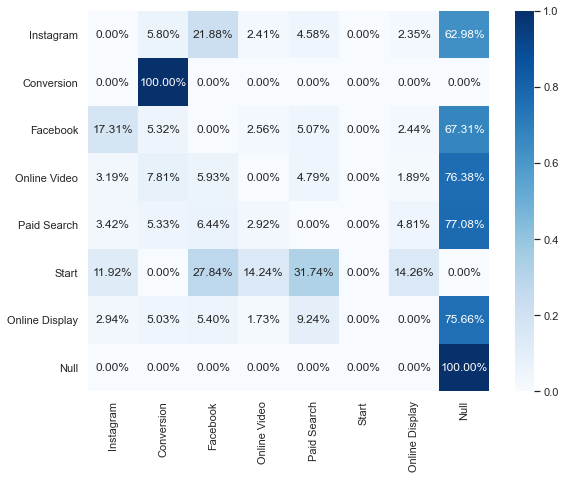

In [47]:
ax = sns.heatmap(trans_matrix, annot=True, fmt='.2%', cmap="Blues")
ax.figure.set_size_inches(9, 7)

- 가장 Null로 전이가 많이되는 채널은 77.08%로 Paid Search이고, 가장 전이가 적게되는 채널은 62.98%로 Instagram이다.
- Instagram에서 Null을 제외하고, 그 다음으로 전이가 많은 채널은 21.88%로 Facebook이다.
    - 인스타그램에서는 페이스북으로 가는 전이 형태로 많이 발생한다는 것을 알 수 있다.
- Start에서는 Paid Search, Facebook 순으로 전이가 가장 높다.
    - 처음 접하는 채널로는 Paid Search, Facebook이 가장 많다.
- Conversion으로 가장 전이가 많은 채널은 7.81%로 Online Video가 가장 높다.

---

## 각 채널의 Removal Effect을 이용한 기여도 분석

#### 처음과 끝의 State를 제외한 State 추출

In [48]:
removal_effects_dict = {}
channels = [
    column for column in trans_matrix.columns if column not in ['Start', 'Null', 'Conversion']
]
print(channels)

['Instagram', 'Facebook', 'Online Video', 'Paid Search', 'Online Display']


In [47]:
trans_matrix

,Conversion,Online Video,Online Display,Facebook,Instagram,Paid Search,Start,Null
Conversion,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Online Video,0.078146,0.000000,0.018920,0.059323,0.031908,0.047947,0.0,0.763757
Online Display,0.050324,0.017299,0.000000,0.053986,0.029363,0.092386,0.0,0.756643
Facebook,0.053220,0.025577,0.024352,0.000000,0.173072,0.050655,0.0,0.673123
Instagram,0.057979,0.024118,0.023531,0.218777,0.000000,0.045809,0.0,0.629786
Paid Search,0.053309,0.029221,0.048053,0.064442,0.034196,0.000000,0.0,0.770779
Start,0.000000,0.142361,0.142644,0.278408,0.119188,0.317399,0.0,0.000000
Null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000


---

### 각 채널에 대한 Removal Effect 계산

In [49]:
# 각 채널을 돌면서
for channel in channels:
    # 해당 채널에 대한 행과 열 제거 (제거 효과 계산을 위해)
    removal_df = trans_matrix.drop(channel, axis=1).drop(channel, axis=0)
    
    # removal_df의 남은 State를 돌면서
    for column in removal_df.columns:
        # 전이행렬의 각 State별 합을 구해
        row_sum = np.sum(list(removal_df.loc[column]))
        
        # 합이 1보다 작을 경우 나머지 부분을 Null부분으로 채워줌 (나머지 부분은 제거한 채널에 대한 전이확률이므로 Null로 변환)
        null_pct = float(1) - row_sum
        if null_pct != 0:
            removal_df.loc[column]['Null'] = removal_df.loc[column]['Null'] + null_pct
    
    # Absorbing States(=R) : 다른 채널에서 마지막 State인 Null, Conversion으로 가는 행렬
    removal_to_conv = removal_df[
        ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
    
    # Transient States(=Q) : 변화하는 State에서 변화하는 State로 가는 행렬 (마지막 State를 제거한 행렬)
    removal_to_non_conv = removal_df.drop(
        ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)
    
    
    # F = (I - Q)의 역행렬
    removal_inv_diff = np.linalg.inv(np.identity(len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
    # F와 R의 내적을 통해 Absorbing Markov Chain 생성
    removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
    
    # Start > Conversion으로 가는 총 전환율 계산 (해당 채널을 제거했을 때의 총 전환율)
    removal_cvr = pd.DataFrame(removal_dot_prod, index=removal_to_conv.index)[[1]].loc['Start'].values[0]
    
    # 기존의 전체 전환율과 제거효과를 통해 전환율에 대한 비율을 1과 뺄셈을 통해 제거 효과 계산
    removal_effect = 1 - removal_cvr / base_conversion_rate
    
    # 해당 제거 효과를 해당 채널에 대한 값으로 삽입
    removal_effects_dict[channel] = removal_effect

#### 채널별 제거 효과를 이용한 기여도

In [51]:
removal_effects_dict

{'Online Video': 0.2069141165564219,
 'Online Display': 0.15435482356041275,
 'Facebook': 0.3547597674182721,
 'Instagram': 0.21731366149038456,
 'Paid Search': 0.3311037560086154}

#### 각 채널에 대한 제거효과를 확률로서 표현
- softmax를 통해 [0, 1] 값으로 정규화

In [51]:
removal_sum = np.sum(list(removal_effects_dict.values()))
for k, v in removal_effects_dict.items():
    removal_effects_dict[k] = v / removal_sum
    
removal_effects_dict

{'Instagram': 0.17186470596722564,
 'Facebook': 0.28056534825372886,
 'Online Video': 0.16364012072941478,
 'Paid Search': 0.26185675249681706,
 'Online Display': 0.12207307255281379}

---

### 채널별 기여도 계산

In [65]:
total_conversions = len(cookie_paths.loc[cookie_paths.conversion == 1, :])
markov_attributions = {k: v * total_conversions for k, v in removal_effects_dict.items()}
markov_attributions

{'Online Video': 2886.4480895461475,
 'Online Display': 2153.2469267590823,
 'Facebook': 4948.892177847523,
 'Instagram': 3031.521548555893,
 'Paid Search': 4618.891257291356}

In [53]:
markov_interaction_attr = pd.DataFrame({'attribution_cnt': markov_attributions.values()}, index=markov_attributions.keys())
markov_interaction_attr

,attribution_cnt
Instagram,3031.521549
Facebook,4948.892178
Online Video,2886.448090
Paid Search,4618.891257
Online Display,2153.246927


---

---

---

# 도메인 기반 모델과 Markov Chain 모델을 통한 기여도 비교

In [54]:
markov_interaction_attr['method'] = 'markov'
total_attribution_df = domain_attr[['attribution_cnt', 'method']].append(markov_interaction_attr)

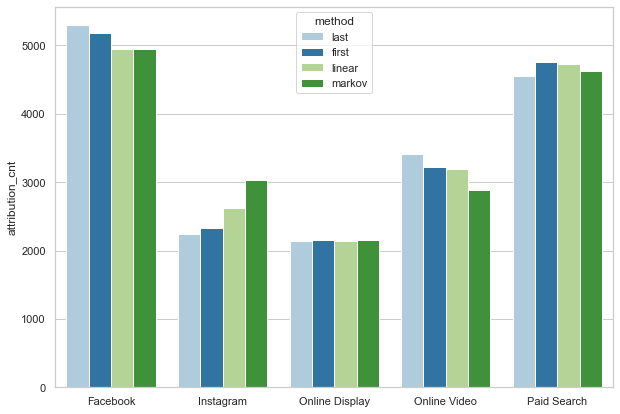

In [69]:
ax = sns.barplot(x=total_attribution_df.index, y=total_attribution_df.attribution_cnt, hue=total_attribution_df.method)
ax.figure.set_size_inches(10, 7)

- 제거 효과를 고려했을 때의 채널별 기여도는 Facebook > Paid Search > Instagram 순으로 높았다.
- 기존 전환율 대비 각 채널이 제거되었을 때의 전환율이 얼마나 감소되었는지를 채널의 기여도로서 계산했기에, 도메인 기반 모델보다 좀 더 데이터 기반의 기여도 분석이라고 할 수 있고, 이를 고려한다면 Facebook > Paid Search > Instagram > Online Video > Online Display 순으로 `removal_effects_dict`의 값으로 예산을 분배할 수 있다.